# Segmentation of Pelvic Fractures in CT Scans
### Jedidiah Schloesser

In [53]:
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torchio as tio
from utils import SubjectsDataset, Evaluator
from models import *

In [54]:
def get_model(model_options):
    
    if model_options['model_class'] == UNet:
        model = UNet(2, model_options['unet_initial_channels'], device)
    else:
        model = model_options['model_class'](2, device)

    model.load_state_dict(torch.load(f"data/{model_options['model_name']}/weights.pth", map_location=device))

    return model

In [55]:
def evaluate_model(model_options, device):

    model = get_model(model_options)
    
    dataset = SubjectsDataset(root='datasets/pengwin/test')
    dataset.set_transform(tio.ZNormalization(masking_method=None))

    if os.path.exists(f"data/{model_options['model_name']}/eval.pkl"):
        with open(f"data/{model_options['model_name']}/eval.pkl", 'rb') as f:
            evaluation = pickle.load(f)
            

    else:
        evaluator = Evaluator(
            model=model,
            dataset=dataset,
            batch_size=256,
            num_classes=2,
            device=device
        )

        avg_dice, avg_iou = evaluator.evaluate()
        evaluation = {
            "dice": avg_dice,
            "iou": avg_iou
        }
        
    return evaluation

In [56]:
def plot_loss(model_options):
    
    losses = pickle.load(open(f"data/{model_options['model_name']}/losses.pkl", 'rb'))
    train_losses = list(map(lambda x: x[0], losses))
    val_losses = list(map(lambda x: x[1], losses))
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Learning Curve ({model_options['model_name']})")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"figs/{model_options['model_name']}.png")
    plt.show()

In [57]:
def compare_models(evaluations):

    models = list(evaluations.keys())
    dice_scores = [evaluations[model]['dice'] for model in models]
    iou_scores = [evaluations[model]['iou'] for model in models]

    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar([i for i in range(len(models))], dice_scores, width=bar_width, label='Dice Score')
    plt.bar([i + bar_width for i in range(len(models))], iou_scores, width=bar_width, label='IOU Score')
    plt.xticks([i + bar_width / 2 for i in range(len(models))], models)
    plt.ylabel('Coefficient Value')
    # plt.ylim(0, 1)
    plt.title('Comparison of Dice and IOU Scores')
    plt.legend()
    plt.show()

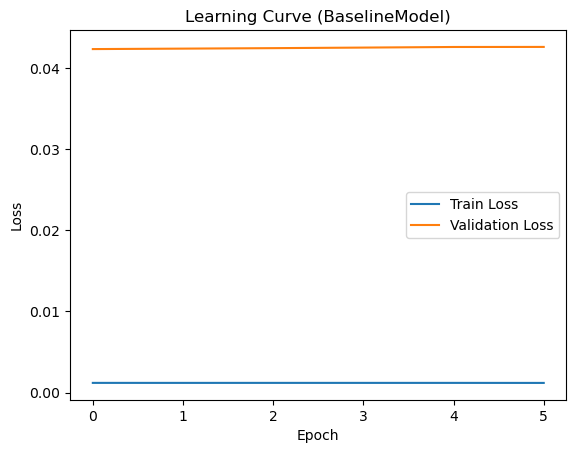

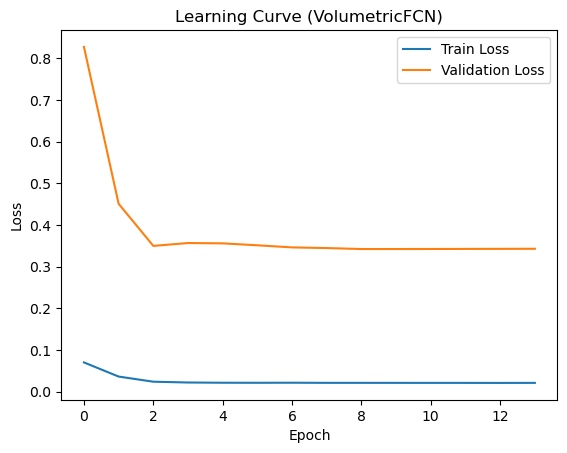

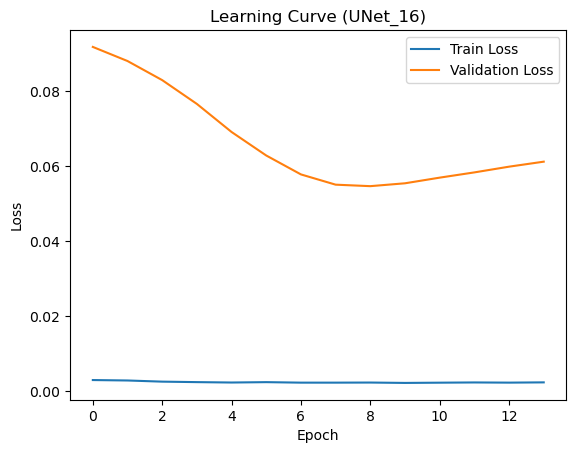

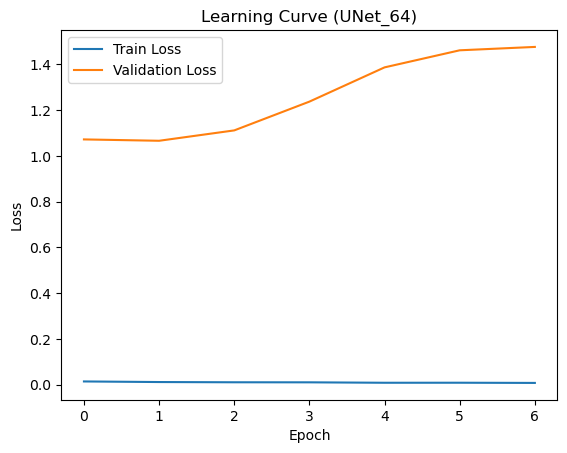

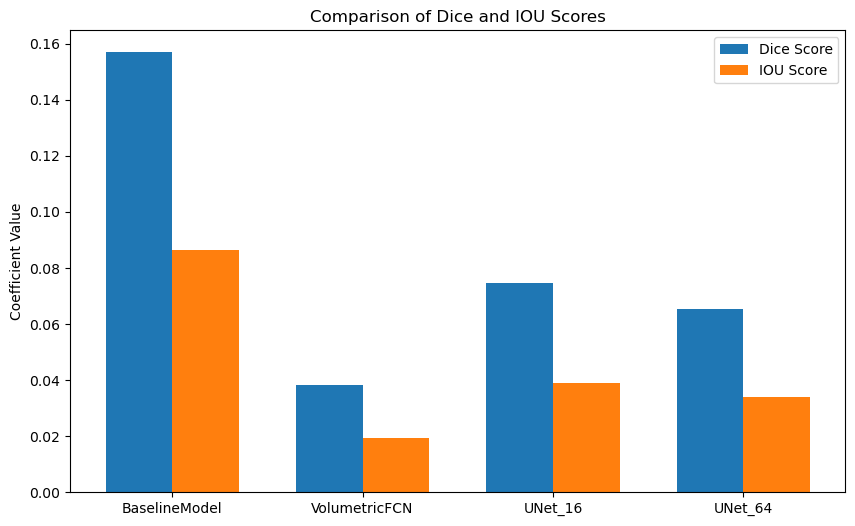

In [58]:
models = [
    {
        'model_class': BaselineModel,
        'model_name': 'BaselineModel'
    },
    {
        'model_class': VolumetricFCN,
        'model_name': 'VolumetricFCN'
    },
        {
        'model_class': UNet,
        'model_name': 'UNet_16',
        'unet_initial_channels': 16
    },
    {
        'model_class': UNet,
        'model_name': 'UNet_64',
        'unet_initial_channels': 64
    },
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluations = {}

for model_options in models:
    evaluations[model_options["model_name"]] = evaluate_model(model_options, device)
    plot_loss(model_options)

compare_models(evaluations)